_version log: Trying to improve the fit on the anti-chirping function by swaping the axes_

In [531]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import os, re
from scipy import interpolate as sciinter, signal as scisig, optimize as sciopt, ndimage as sciimage
plt.rcParams.update({'font.size':14})

c = 299_792_458
source = "FBH1600" # "blue" "green" "red" "FBH800" "FBH1600" "ir" "big"
run = "6"
camera = "xeva" #"xeva" for importing .csv files, "manta" for importing .tif
dead_pixels = 1 # % of most anomalous pixels to replace with its nearest neighbour
anti_chirping = True #True for applying Elin's anti-chirping code.
zero_padding = 2 #factor to extrapolate the interferogram by. 1 means no extrapolation. 2 means that the interferogram will double in length. This should interpolate the spectrum rather than improving resolution.
apodization_function = "blackmann-harris" # None "box" "triangular" "happ-genzel" "blackmann-harris". None and "box" are identical unless you add zero-padding.
angle_calculation_method = "manual" # "manual" for a known angle, "wavelength" for calibration with a known wavelength or "delay" for calulation using a temporal change on the delay line.
angle_between_beams = 13.3/60 #degrees. Used if angle_calculation_method == "manual"
delay_line_delta = 2 #um. Distance traveled by delay line between each reading. Used if angle_calculation_method == "delay"
calibration_wavelength = 1.6 #um. Used if angle_calculation_method == "wavelength"

if camera == "manta":
    pixel_pitch = 9.9 #um
elif camera == "xeva":
    pixel_pitch = 20 #um

In [532]:
#################FUNCTIONS##################

def line(x,A,B):
    return A + B*x
     
def cubic(x,A,B,C,D):
     return A + B*x + C*x**2 + D*x**3

def cubic_residuals(x, y, A, B, C, D):
    return cubic(x, A, B, C, D) - y

def zero_pad(interferogram, zero_padding):
    original_length = len(interferogram)
    interferogram = np.concatenate([[interferogram[0]] *int((zero_padding-1) *original_length //2), interferogram])
    interferogram = np.concatenate([interferogram, [interferogram[-1]] *int((zero_padding-1) *original_length //2)])
    return interferogram

def apodization(interferogram, max_index, function = None, L = None):
    if L == None: # The defult definition of L is dependent on interferogram so it must be assigned after interferogram is defined.
        L = len(interferogram) # L is the length of the region to apodize over. The zero-padded region lies outside L
    else:
        max_index += (zero_padding-1) *L //2 # because the interferogram has been extended, the max_index has changed.

    index = np.arange(0, len(interferogram)) # We need indexes if we want to apply apodization

    if function == None:
        return interferogram # leave unchanged
    if function == "box":
        box_function = [1 if i >= (zero_padding-1) *L //2 and i < (zero_padding+1) *L //2 else 0 for i in index] # apply boundries. Box function is invalid in zero-padded regions.
        box_function = np.array(box_function)
        return interferogram
    if function == "triangular":
        triangular_function = 1 - np.abs(2/L *(index-max_index)) #definition of function
        triangular_function = [y if y >= 0 else 0 for y in triangular_function] #apply boundries. Negative values are invalid.
        triangular_function = np.array(triangular_function)
        interferogram = interferogram * triangular_function
        return interferogram
    if function == "happ-genzel":
        happ_genzel_function = 0.54 +0.46*np.cos(np.pi/L *(index-max_index)) #definition of function
        happ_genzel_function = [happ_genzel_function[i] if (i-max_index)/L >= -1 and (i-max_index)/L <= 1 else 0.08 for i in index] #apply boundries. Only the first period of the cosine is valid.
        happ_genzel_function = np.array(happ_genzel_function)
        return interferogram * happ_genzel_function
    if function == "blackmann-harris":
        blackmann_harris_function = 0.42323 +0.49755*np.cos(np.pi/L *(index-max_index)) +0.07922*np.cos(2*np.pi/L *(index-max_index)) #definition of function. This is the 3-term blackmann-harris.
        blackmann_harris_function = [blackmann_harris_function[i] if (i-max_index)/L >= -1 and (i-max_index)/L <= 1 else 0.0049 for i in index] #apply boundries. Only the first period of the cosine is valid.
        blackmann_harris_function = np.array(blackmann_harris_function)
        return interferogram * blackmann_harris_function


#Elin's anti-chirping function
def regularspacing(calibration, interferogram): #calibration intensities, interferogram intensities
    calibrationsmooth = sciimage.median_filter(calibration, 2) #reduces noise and dead pixels
    calibration_index = np.arange(ROI[0], ROI[1]) #create indexes for calibration.
    constructive_locs, _ = scisig.find_peaks(calibrationsmooth, width= 4) #locations of the contractive interferance.
    destructive_locs, _ = scisig.find_peaks(-calibrationsmooth, width= 4) #locations of the destructive interferance.
    fringe_locs = np.concatenate([constructive_locs, destructive_locs])
    fringe_locs = np.sort(fringe_locs)
    fringe_locs += ROI[0] #len(calibration) != len(interferogram) so we need to compensate for the change in index.

    liniar_locs = np.linspace(fringe_locs[0], fringe_locs[-1], len(fringe_locs)) #liniarly spaced version of the fringe locations
    
    coeffs, pcov = sciopt.curve_fit(cubic, liniar_locs, fringe_locs, bounds= ([-100,0,-1,0],[100,2,1,1]))
    print(np.linalg.cond(pcov)) #higher numbers mean worse fits.

    liniar_index = sciopt.root(cubic_residuals, calibration_index, args=(calibration_index, *coeffs)).x #liniarise the indexes. Numerically solves the cubic equation.
    unchirped_intensity = np.interp(calibration_index, liniar_index, calibration) #map the indexes to the interferogram using liniar interpolation where nessisary.

    interferogram_index = np.arange(0, len(interferogram))
    extra_liniar_index = sciopt.root(cubic_residuals, interferogram_index, args=(interferogram_index, *coeffs)).x #liniarise the indexes
    extra_unchirped_intensity = np.interp(interferogram_index, extra_liniar_index, interferogram) #map the indexes to the interferogram using liniar interpolation where nessisary.

    plt.figure(figsize= (12,6))

    plt.subplot(1,2,1)
    plt.plot(fringe_locs, liniar_locs, marker= "x", linestyle = "None", label= "sampled points")
    plt.plot(interferogram_index, extra_liniar_index, label = str(coeffs))
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(interferogram)
    plt.plot(extra_unchirped_intensity)
    plt.vlines(ROI, np.min(interferogram), np.max(interferogram), color = "k")
    plt.show()

    return unchirped_intensity, extra_unchirped_intensity # unchirped intensities, extrapolated unchirped intensities

def import_standard_photo(colour, number):
    if camera == "manta":
        im = Image.open('data\\'+colour+'_fringes'+number+'.tif')
        fringes = np.array(im, dtype= np.float32)
        im = Image.open('data\\'+colour+'_BA'+number+'.tif')
        beamA = np.array(im, dtype= np.float32)
        im = Image.open('data\\'+colour+'_BB'+number+'.tif')
        beamB = np.array(im, dtype= np.float32)
        im = Image.open('data\\'+colour+'_bg'+number+'.tif')
        background = np.array(im, dtype= np.float32)
    elif camera == "xeva":
        fringes = np.loadtxt('data\\'+colour+'_fringes'+number+'.csv', delimiter=";")
        beamA = np.loadtxt('data\\'+colour+'_BA'+number+'.csv', delimiter=";")
        beamB = np.loadtxt('data\\'+colour+'_BB'+number+'.csv', delimiter=";")
        background = np.loadtxt('data\\'+colour+'_bg'+number+'.csv', delimiter=";")
    return fringes, beamA, beamB, background

def find_angle_files(colour, number):
    file_names = os.listdir("data\\")
    new_file_names=[]
    new_file_numbers=[]
    for file_name in file_names:
        if camera == "manta":
            check = re.findall(colour+'_fringes'+number+'_[0-9]+.tif' , file_name)
        elif camera == "xeva":
            check = re.findall(colour+'_fringes'+number+'_[0-9]+.csv' , file_name)
        if len(check) != 0:
            new_file_names = new_file_names + [file_name]

            file_number = re.findall('[0-9]+' , file_name)
            new_file_numbers = new_file_numbers + [int(file_number[-1]) -1] #the number that we are looking for is always the last number in the file name
    df = pd.DataFrame(np.transpose([new_file_names, new_file_numbers]), columns= ["file names", "file numbers"])
    df["file numbers"] = [int(number) for number in df["file numbers"]] #pandas forgot that numbers are intergers
    df = df.sort_values("file numbers", ignore_index= True) #I still don't know how to sort values using a key with numpy
    return df["file names"], df["file numbers"]

def combine_angle_arrays(file_names):
    if camera == "manta":
        im = Image.open('data\\'+file_names[0]) #for the first interferogram
        angles = np.array(im, dtype= np.float32)
        for file_name in file_names[1:]: #for every other interferogram
            im = Image.open('data\\'+file_name)
            Array = np.array(im, dtype= np.float32)
            angles = np.dstack([angles,Array])
    elif camera == "xeva":
        angles = np.loadtxt('data\\'+file_names[0], dtype= np.float32, delimiter=";")
        for file_name in file_names[1:]: #for every other interferogram
            Array = np.loadtxt('data\\'+file_name, dtype= np.float32, delimiter=";")
            angles = np.dstack([angles,Array])

    return angles

def dead_pixel_filter(beamPost):
    # Remove the most anomalous 1% of pixels and replace with nearest nearbour.
    upper_percentile = 100 - dead_pixels/2
    lower_percentile = dead_pixels/2
    notdead = np.logical_and(beamPost < np.percentile(beamPost,upper_percentile), beamPost > np.percentile(beamPost,lower_percentile) )
    coords = np.mgrid[0:beamPost.shape[0], 0:beamPost.shape[1]]
    coords = np.moveaxis(coords, 0, -1) #refromat the array such that we have pairs of coordinates. ie. [[0,0],[0,1],[0,2]] ect.
    nearest = sciinter.NearestNDInterpolator(coords[notdead], beamPost[notdead])
    beamPost = nearest(coords[:,:,0],coords[:,:,1])

    return beamPost

def process_fringes(fringes, beamA, beamB, background):
    if fringes.ndim == 3:
        nofringes = np.dstack([beamA +beamB -background] *fringes.shape[2]) #This will throw an error if fringes is 2d
        beamPost = fringes - nofringes #take away background.
        if dead_pixels == True:
            for n in np.arange(0,beamPost.shape[0]):
                beamPost[n] = dead_pixel_filter(beamPost[n]) #I can't figure out how to vectorise this bit :/

    elif fringes.ndim == 2:
        nofringes = beamA +beamB -background #ignore the error
        beamPost = fringes - nofringes #take away background.
        if dead_pixels == True:
            beamPost = dead_pixel_filter(beamPost)

    beamPost -= np.mean(beamPost)

    return beamPost, nofringes

def apply_cross_corrlations(angle_averages, reference_signal, reference_offset = 0):
        
    if angle_averages.ndim == 1:
        cross_corr = scisig.correlate(reference_signal, angle_averages, mode='same') #use average_signal as a referance to find the displacements.
        lags = scisig.correlation_lags(len(reference_signal), len(angle_averages), mode="same")
        displacements = lags[np.argmax(cross_corr)] - reference_offset #*pixel_pitch #convert from indexes to um.

    elif angle_averages.ndim == 2:
        cross_corr = scisig.correlate(reference_signal, angle_averages[:,0], mode='same') #use average_signal as a referance to find the displacements.
        lags = scisig.correlation_lags(len(reference_signal), len(angle_averages[:,0]), mode="same") + len(reference_signal)//2
        displacements = lags[np.argmax(cross_corr)] - reference_offset #*pixel_pitch #convert from indexes to um.

        for n in np.arange(1,angle_averages.shape[1]): #for every other interferogram
            cross_corr = scisig.correlate(angle_averages[:,n], reference_signal, mode='same') #use average_signal as a referance to find the displacements.
            lags = scisig.correlation_lags(len(reference_signal), len(angle_averages[:,n]), mode="same") + len(reference_signal)//2
            displacement = lags[np.argmax(cross_corr)] - reference_offset #*pixel_pitch #convert from indexes to um.
            displacements = np.hstack([displacements,displacement])

    return displacements, cross_corr

def Coeffients2Amplitudes(FT, freqs):
    samples = len(FT)
    num_of_freqs = len(FT)//2 +1
    amplitude = np.zeros(num_of_freqs)
    amplitude[0] = np.abs(FT[0])
    if (samples//2 == samples/2): #if even
        amplitude[-1] = np.abs(FT[num_of_freqs-1])
        amplitude[1:-1] = (np.abs( FT[1:num_of_freqs-1] ) +
                            np.abs( FT[:num_of_freqs-1:-1] ))

        freqs = freqs[:num_of_freqs]
        freqs[-1] = -freqs[-1] #The niquist freqency is considered to be negative by np.fft.fftfreq(). This should make it positive.
        wavelengths = 1/freqs
    else: #if odd
        amplitude[1:] = (np.abs( FT[1:num_of_freqs] ) +
                        np.abs( FT[:num_of_freqs-1:-1] ))
        
        freqs = freqs[:num_of_freqs]
        wavelengths = 1/freqs
    return amplitude, wavelengths, freqs

def import_normalised_csv(file_name, start_row):
    File = open('data\\'+file_name, 'rt')
    array = np.loadtxt(File, skiprows=start_row, delimiter = ",")
    File.close()
    array[:,1] = array[:,1] / np.max(array[:,1]) #normalise
    return array

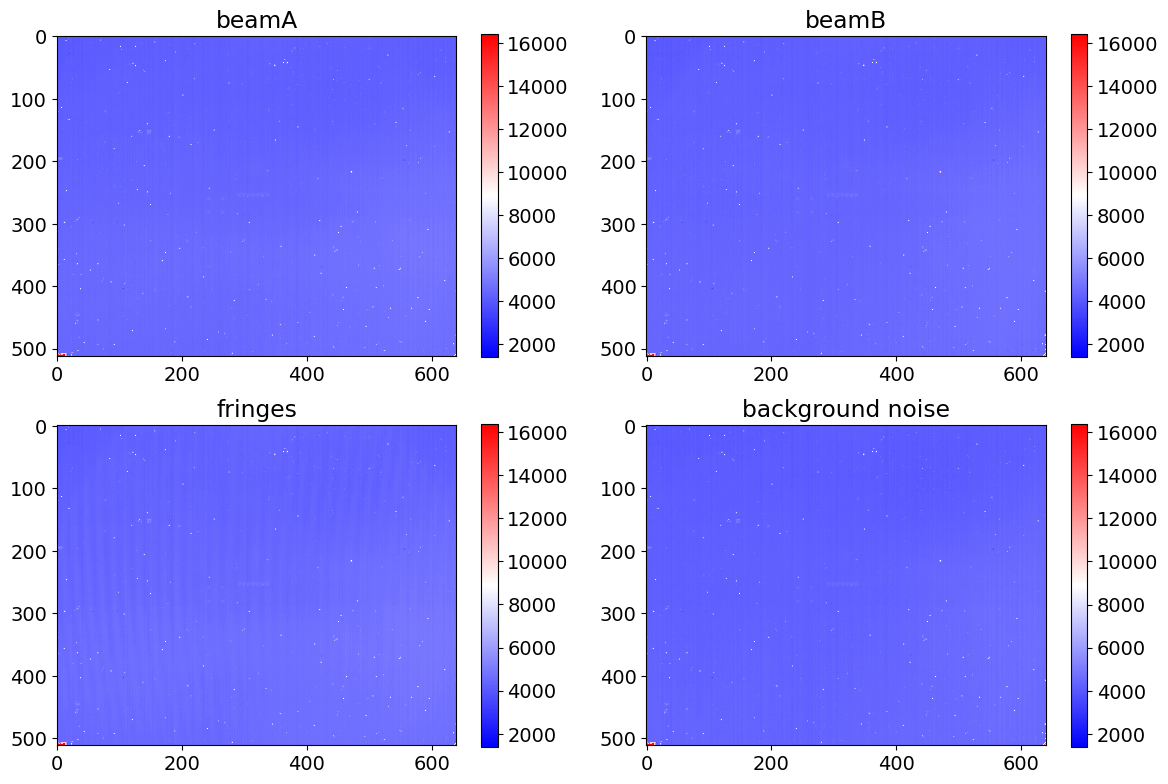

In [533]:
fringes, beamA, beamB, background = import_standard_photo(source, run)

plt.figure(figsize= (12,8))

plt.subplot(2,2,1)
im=plt.imshow(beamA, cmap='bwr')
plt.colorbar(im)
plt.title("beamA")

plt.subplot(2,2,2)
im=plt.imshow(beamB, cmap='bwr')
plt.colorbar(im)
plt.title("beamB")

plt.subplot(2,2,3)
im=plt.imshow(fringes, cmap='bwr')
plt.colorbar(im)
plt.title("fringes")

plt.subplot(2,2,4)
im=plt.imshow(background, cmap='bwr')
plt.colorbar(im)
plt.title("background noise")

plt.tight_layout()
plt.show()

In [534]:
beamPost, nofringes = process_fringes(fringes, beamA, beamB, background)
average_signal = np.mean(beamPost, axis = 0)

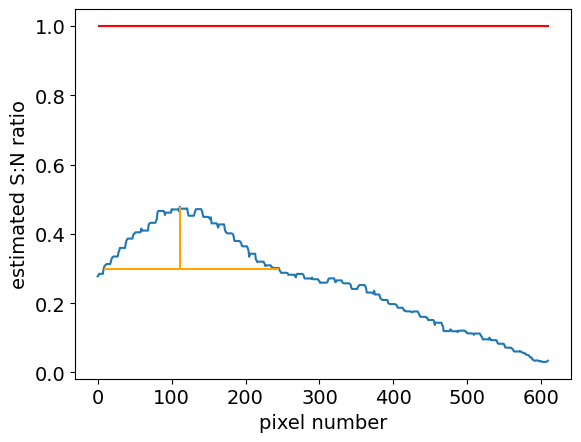

In [535]:
window_width = 30 #should be at least 1 period

# I've defined the signal as the differnence between the peaks and the troughs of the processed interferogram. THIS IS NOT A GREAT ESTIMATION BECAUSE THE BEAM PROFILE IS NOT UNIFORM.
signal = np.array([np.diff(np.percentile(np.mean(beamPost, axis = 0)[n:n+window_width], [10,90]))[0] for n in np.arange(0, len(average_signal)-window_width)])
# I've defined the noise as the differance between the peaks and troughs of the background image. THIS IS NOT A GREAT ESTIMATION BECAUSE THE BACKGROUND IS NOT UNIFORM.
noise = np.array([np.diff(np.percentile(np.mean(background, axis = 0)[n:n+window_width], [10,90]))[0] for n in np.arange(0, len(average_signal)-window_width)])

noise = np.mean(noise) #Assume that the noise is constant. This is not nessisarally the case.

S2N = signal / noise

peaks, peak_properties = scisig.find_peaks(S2N, prominence = 0, height = 0, width = 0, rel_height= 0.9) #prominence = the smallest peak that can be considered a signal rather than noise. It would be nice to calculate this.
best_peak = np.argmax(peak_properties["prominences"])
max_index = peaks[best_peak]
left_idx = peak_properties["left_ips"][best_peak]
right_idx = peak_properties["right_ips"][best_peak]
peak_height = peak_properties["peak_heights"][best_peak]
S2N_threshold = peak_properties["width_heights"][best_peak]

ROI = [int(left_idx +window_width/2), int(right_idx +window_width/2)]

plt.plot(S2N)
plt.ylabel("estimated S:N ratio")
plt.xlabel("pixel number")
plt.hlines([1, S2N_threshold], [0, left_idx], [len(signal), right_idx], color = ["red","orange"])
plt.vlines(max_index, S2N_threshold, peak_height, color= "orange")
plt.show()

max_index += window_width//2 #We will need this later. Because of the window width, len(S2N) != len(average_signal).

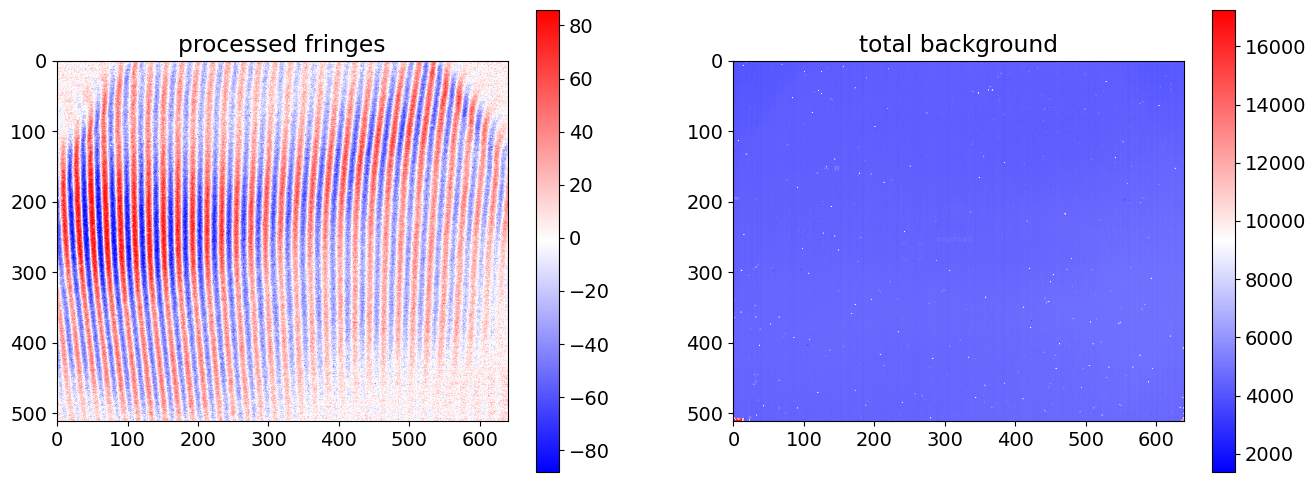

In [536]:
plt.figure(figsize = (16,6))

ax = plt.subplot(1,2,1)
im=plt.imshow(beamPost, cmap='bwr')
plt.colorbar(im)
plt.title("processed fringes")

plt.subplot(1,2,2)
im=plt.imshow(nofringes, cmap='bwr')
plt.colorbar(im)
plt.title("total background")

plt.show()

2743428709028700.5


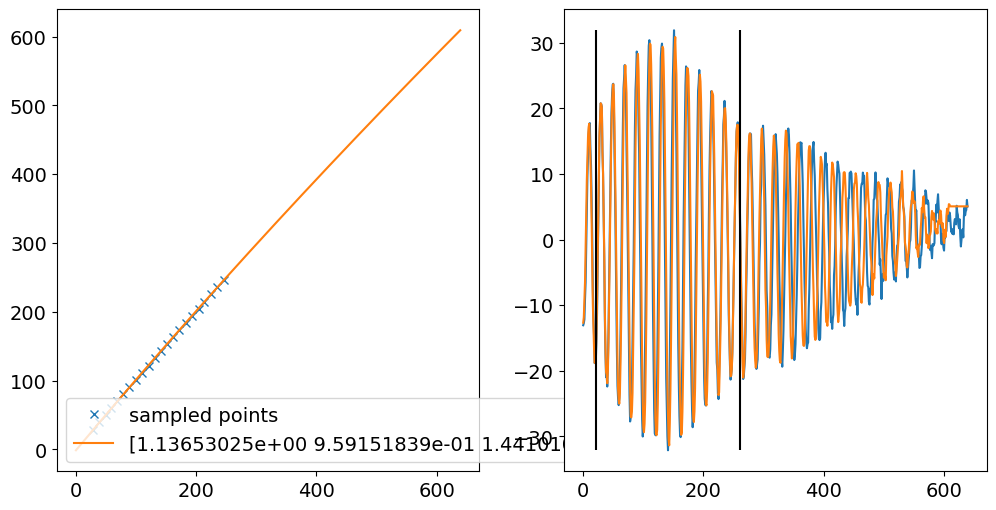

In [537]:
if anti_chirping == True:
    test, average_signal2 = regularspacing(average_signal[ROI[0]:ROI[1]], average_signal)
else:
    average_signal2 = average_signal

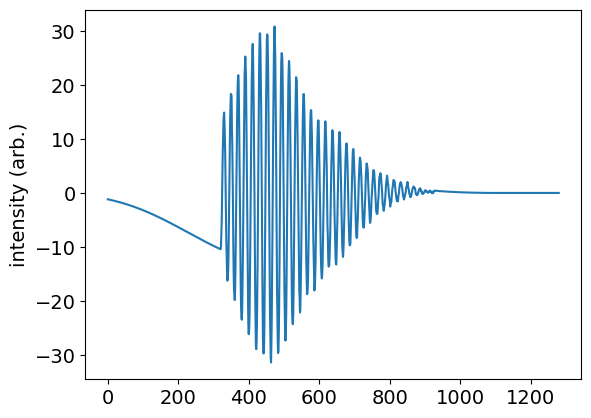

In [538]:
max_index += window_width//2

average_signal2 = zero_pad(average_signal2, zero_padding)
average_signal2 = apodization(average_signal2, max_index, function= apodization_function, L= len(average_signal))

plt.plot(average_signal2)
plt.ylabel("intensity (arb.)")
plt.show()

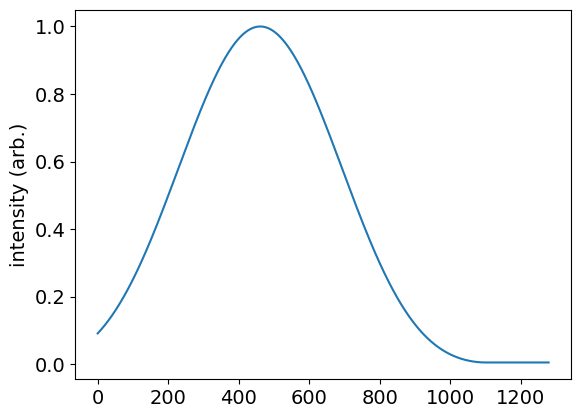

In [539]:
dummy = np.ones(average_signal2.shape)
dummy = apodization(dummy, max_index, function = apodization_function, L= len(average_signal))
plt.plot(dummy)
plt.ylabel("intensity (arb.)")
plt.show()

In [540]:
delay_line_bounds = [1,-4] #As the fringes move outside of the ROI, the peak position becomes inaccurate.

if angle_calculation_method == "delay":

    file_names, file_numbers = find_angle_files(source, run)
    angles = combine_angle_arrays(file_names)
    angles, _ = process_fringes(angles, beamA, beamB, background)
    angle_averages = np.mean(angles, axis = 0)
    

    delay_line_travel = np.arange(angle_averages.shape[1]) *delay_line_delta
    time_delay = delay_line_travel *2 /c
    time_delay *= 1e9 #convert from us to fs

    maximums = np.argmax(angle_averages, axis = 0)
    minimums = np.argmin(angle_averages, axis = 0)
    reference_offset = len(average_signal)//2 - max_index
    cross_corr, _ = apply_cross_corrlations(angle_averages, average_signal, reference_offset= reference_offset)

    all_peak_estimates = np.concatenate((maximums[delay_line_bounds[0]:delay_line_bounds[1]], minimums[delay_line_bounds[0]:delay_line_bounds[1]])) #, cross_corr[delay_line_bounds[0]:delay_line_bounds[1]]))
    time_delays = list(time_delay[delay_line_bounds[0]:delay_line_bounds[1]])*2

    popt, pcov = sciopt.curve_fit(line, all_peak_estimates, time_delays)
    k = popt[0]
    m = popt[1]
    err_k = np.sqrt(pcov[0][0]) /k #make into percentage error
    err_m = np.sqrt(pcov[1][1]) /m

    plt.figure(figsize = (12,8))

    ax = plt.subplot(1,1,1)
    im=plt.imshow(np.transpose(angle_averages), 
                cmap='bwr', 
                aspect = "auto", 
                interpolation = "none", #"none" and "nearest" are the only physical ones
                origin = "lower", 
                extent=[0, angle_averages.shape[0], 0 -time_delay[1]//2, time_delay[-1] +time_delay[1]//2])
    plt.colorbar(im)
    plt.plot(maximums,
            time_delay,
            label = "maximums",
            marker = "x")
    plt.plot(minimums,
            time_delay,
            label = "minimums",
            marker = "x")
    plt.plot(cross_corr,
            time_delay,
            label = "cross-correlation",
            marker = "x")
    
    plt.hlines([time_delay[delay_line_bounds[0]],time_delay[delay_line_bounds[1]]], 0, len(average_signal), color = "k")
    plt.vlines(len(average_signal)//2, 0 -time_delay[1]//2, time_delay[-1] +time_delay[1]//2) ############################NEED TO COMPENSATE FOR REFERANCE INTERFEROGRAM FRINGE OFFSET!!! ALL CROSS-COLLELATION LAGS ARE OFF BY EXACTLY THIS OFFSET! 
    plt.ylabel('delay due to delay line (fs)')
    plt.xlabel('position of peak (pixels)')
    plt.legend()

    plt.show()

In [541]:
if angle_calculation_method == "delay":
    print("gradient = {0:.2e} +/- {1:.1e} ".format(m, err_m*m) + "fs/pixel")

    m /= 1e9 *pixel_pitch #convert the gradient from fs/pixel to um/us (= m/s)
    theta = np.arcsin(c *np.abs(m) /2 ) 
    angle_between_beams = 2 *theta *180/np.pi #convert from radians to degrees
    err_angle = angle_between_beams *np.abs(err_m) #relies on the small angle appoximation. This is an underestimate.
    print("angle between beams = {0:.3f} +/- {1:.3f}° or {2:.1f} +/- {3:.1f} arcminutes".format(angle_between_beams, 2*err_angle, 60*angle_between_beams, 60*2*err_angle))

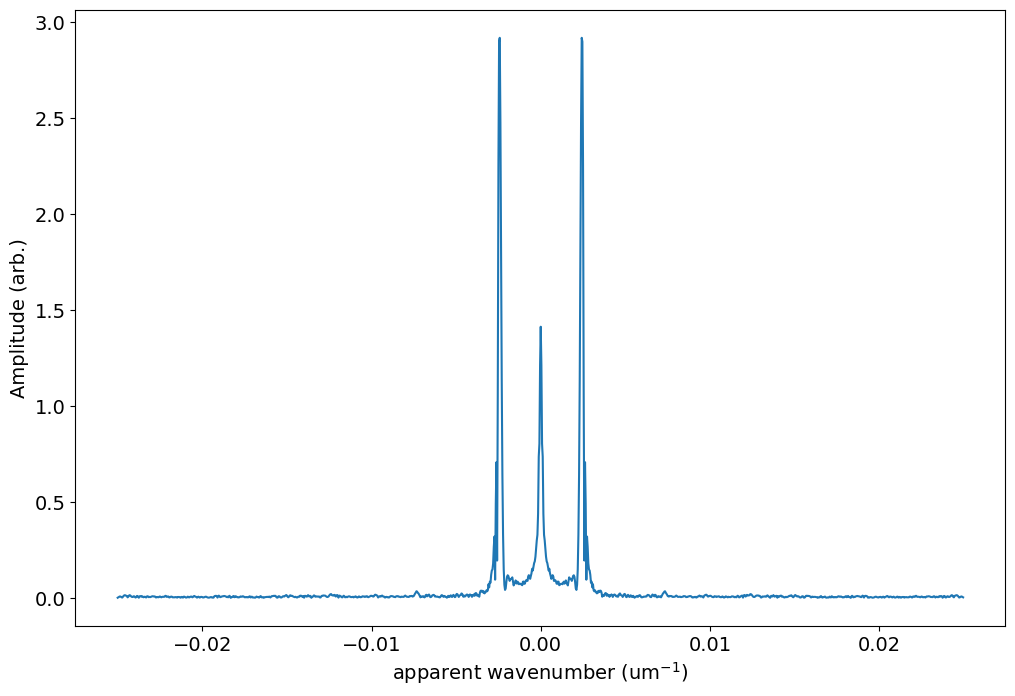

In [542]:
FT = np.fft.fft(average_signal2, norm = "forward")

num_of_freqs = len(FT)//2 +1
samples = len(FT)
freqs = np.fft.fftfreq(len(FT), pixel_pitch)

plt.figure(figsize = (12,8))
plt.subplot(1, 1, 1)

plt.plot(np.fft.fftshift(freqs), #plt works best when the data set is in order
        np.fft.fftshift(abs(FT)))

plt.xlabel('apparent wavenumber (um$^{-1}$)')
plt.ylabel('Amplitude (arb.)')

plt.show()

C:\Users\syf83691\AppData\Local\Temp\ipykernel_16032\1282037365.py:201: RuntimeWarning: divide by zero encountered in divide
  wavelengths = 1/freqs


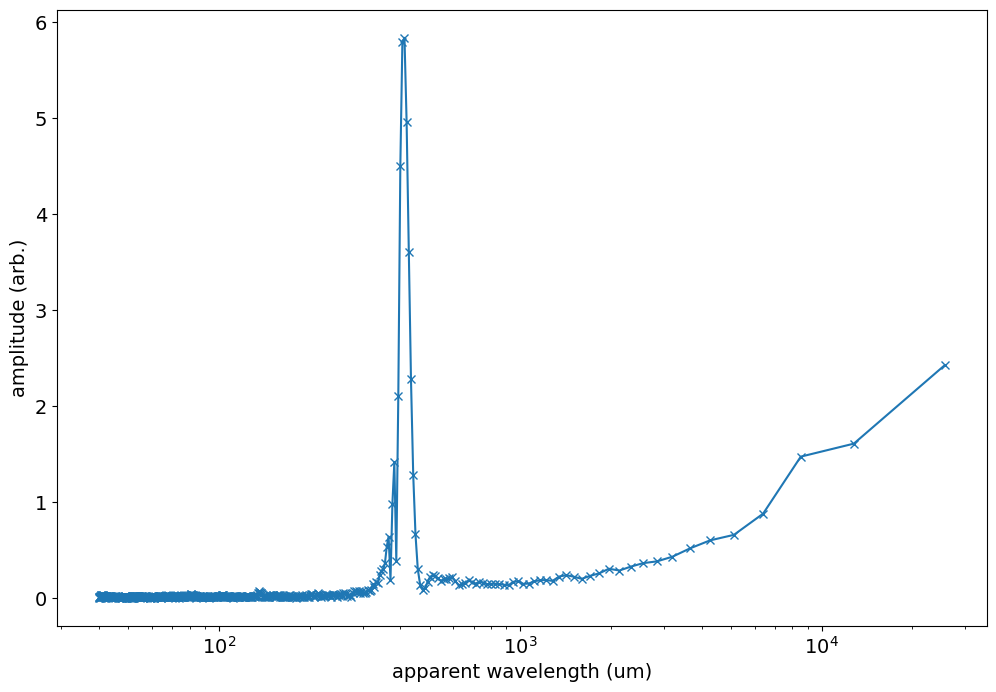

In [543]:
amplitude = np.zeros(num_of_freqs)
amplitude[0] = np.abs(FT[0])
amplitude, wavelengths, freqs = Coeffients2Amplitudes(FT, freqs)

plt.figure(figsize = (12,8))
plt.subplot(1, 1, 1)

plt.plot(wavelengths,
        amplitude,
        marker = "x")
plt.xlabel('apparent wavelength (um)')
plt.ylabel('amplitude (arb.)')
plt.xscale("log")
plt.show()

In [544]:
################COMPENSATE FOR ANGLE#################
if angle_calculation_method == "manual":
    theta = angle_between_beams/2 *np.pi/180
if angle_calculation_method == "wavelength":

    peaks, peak_properties = scisig.find_peaks(amplitude[1:], prominence = 0)
    best_peak = np.argmax(peak_properties["prominences"])
    max_index = peaks[best_peak] +1

    theta = np.arcsin(calibration_wavelength /2 /wavelengths[max_index])
    angle_between_beams = 2 *theta *180/np.pi #convert from radians to degrees
    print("angle between beams = {0:.3f}° or {1:.1f} arcminutes".format(angle_between_beams, 60*angle_between_beams))

corrected_wavelengths = wavelengths *2*np.sin(theta)

###################CREATING AN EXPECTED SPECTRUM USING MANUFACURER DATA################## #I made a mess here. Pls clean up.

amplitude = amplitude /np.nanmax(amplitude[:-1]) #normalise

camera_data = import_normalised_csv("mantra_spectrum.csv", 0)
camera_data[:,0] *= 1e-3 #convert to um
camera_function = sciinter.interp1d(camera_data[:,0], camera_data[:,1], fill_value= np.nan, bounds_error= False)

ir_data = import_normalised_csv("SLS201L_spectrum.csv", 1)
ir_data[:,0] *= 1e-3 #convert to um
ir_function = sciinter.interp1d(ir_data[:,0], ir_data[:,1], fill_value= np.nan, bounds_error= False) #Also try fill_value= np.nan

big_data = import_normalised_csv("SLS303_spectrum.csv", 1)
big_data[:,0] *= 1e-3 #convert to um
big_function = sciinter.interp1d(big_data[:,0], big_data[:,1], fill_value= np.nan, bounds_error= False) #Also try fill_value= np.nan

def manufacturers_function(x):
        return (ir_function(x)**(source == "ir") * #source_function if true, 1 if false. I'm kinda proud of this. I think it's a neat solution.
                big_function(x)**(source == "big") *
                camera_function(x)**(camera == "manta"))

percentagediff = (manufacturers_function(corrected_wavelengths[:-1]) - amplitude[:-1]) /amplitude[:-1]
amplitude *= np.nanpercentile(percentagediff[percentagediff != -1], 1) +1 #re-scale to fit

normalised_amplitude = amplitude[:-1] / camera_function(corrected_wavelengths[:-1]) #factor in the camera sensitivity

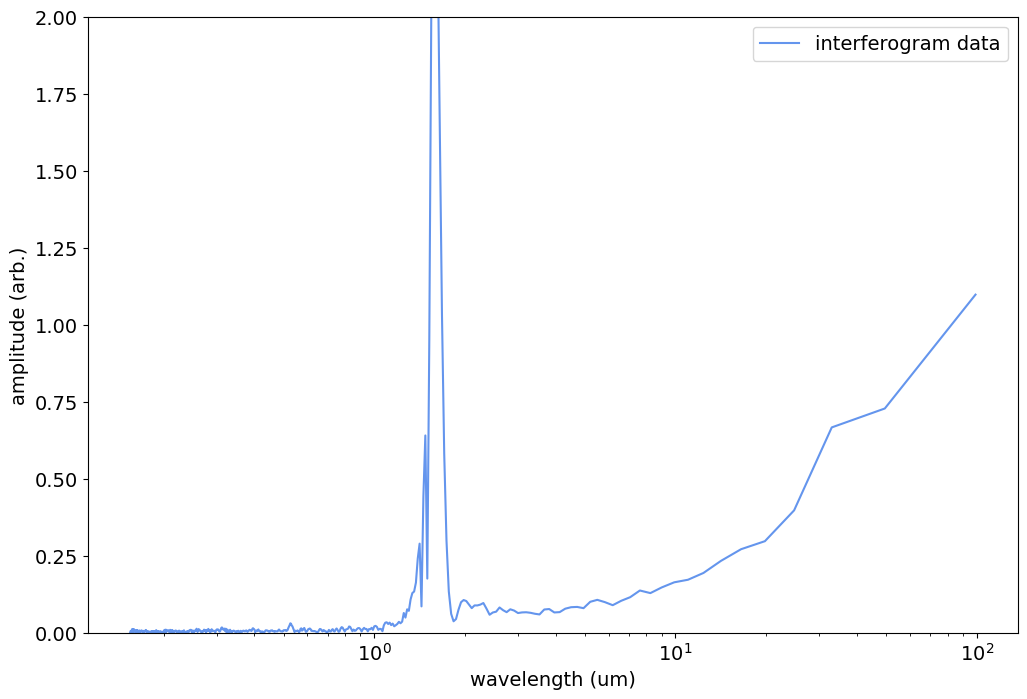

In [545]:
plt.figure(figsize = (12,8))
plt.subplot(1, 1, 1)

if camera == "manta":
        plt.plot(camera_data[:,0],
                camera_data[:,1],
                label = "Manta camera spectral responce",
                color = "orange",
                linestyle = "--")
        plt.plot(corrected_wavelengths[1:],
                normalised_amplitude,
                label = "normalised interferogram data",
                color = "blue")
if source == "ir":
        plt.plot(ir_data[:,0],
                ir_data[:,1],
                label = "SLS201L source spectrum",
                color = "red")
elif source == "big":
        plt.plot(big_data[:,0],
                big_data[:,1],
                label = "SLS303 source spectrum",
                color = "red")
elif angle_calculation_method == "wavelength":
        try:
                plt.axvline(calibration_wavelength, color = source)
        except ValueError:
                plt.axvline(calibration_wavelength, color = "k")

plt.plot(corrected_wavelengths,
        amplitude,
        label = "interferogram data",
        color = "cornflowerblue")

plt.xlabel('wavelength (um)')
plt.ylabel('amplitude (arb.)')
plt.xscale("log")
plt.ylim(0,2)
plt.legend()
plt.show()

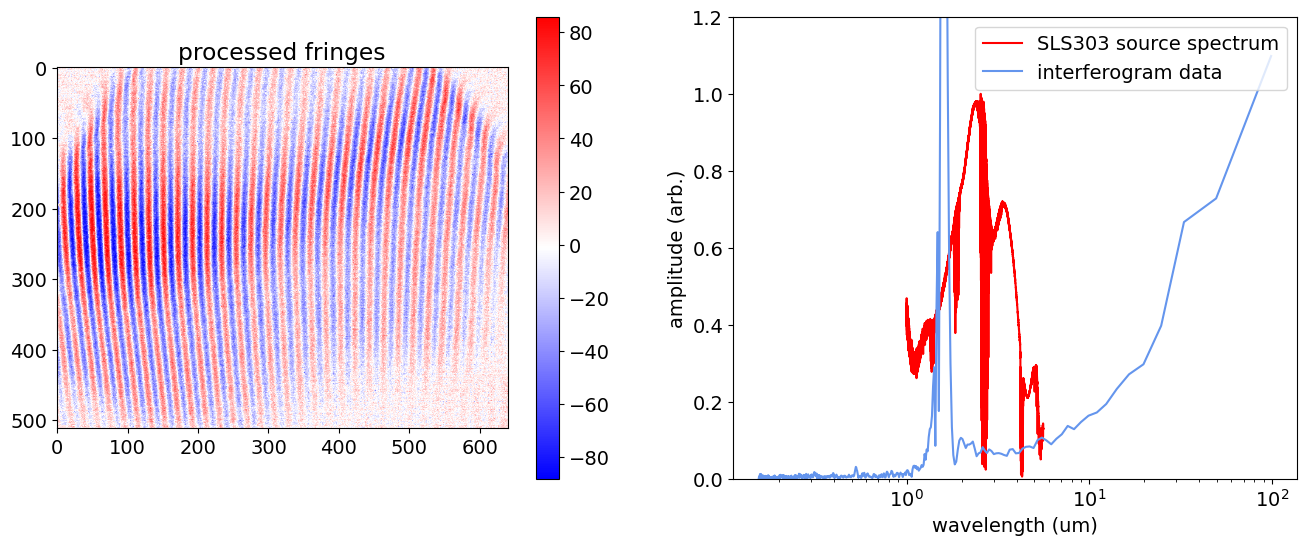

In [546]:
plt.figure(figsize = (16,6))

ax = plt.subplot(1,2,1)
im=plt.imshow(beamPost, cmap='bwr')
plt.colorbar(im)
plt.title("processed fringes")

ax2 = plt.subplot(1,2,2)
plt.plot(big_data[:,0],
        big_data[:,1],
        label = "SLS303 source spectrum",
        color = "red")
plt.plot(corrected_wavelengths,
        amplitude,
        label = "interferogram data",
        color = "cornflowerblue")
plt.xlabel('wavelength (um)')
plt.ylabel('amplitude (arb.)')
plt.xscale("log")
plt.ylim(0,1.2)
plt.legend()
plt.show()